### Notebook for the cell-cell interaction research of healthy gut with liana package

- **Developed by:** Anna Maguza
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 3rd March 2023

### Import required modules

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import liana as li

### Set up working environment

In [3]:
%matplotlib inline

In [4]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.0
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fontTools                   4.38.0
h5py                        3.8.0
importlib_resources         NA
ipykernel                   6.19.2
ipython_genutils            0.2.0
jedi                        0.18.1
joblib                      1.2.0
jupyter_server              1.23.6
kiwisolver                  1.4.4
liana                       0.1.7
llvmlite                    0.39.1
matplotlib                  3.7.0
matplotlib_inline           0.1.6
mizani                      0.8.1
mpl_toolkits                NA
natsort

### Data Upload

In [19]:
input = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/Reference_maps/GCA_Stem_cells/All_cell_types/All_cell_types_after_scanvi.h5ad'
output = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/Reference_maps/GCA_Stem_cells/All_cell_types/All_cell_types_after_scanvi_output.h5ad'

In [20]:
andata = sc.read_h5ad(input)
andata.X

/home/icb/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


<375293x40144 sparse matrix of type '<class 'numpy.float32'>'
	with 649526885 stored elements in Compressed Sparse Row format>

In [ ]:
sc.pp.neighbors(andata, n_neighbors=50, metric = 'minkowski')

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:04:08)


/home/icb/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:06:59)


In [ ]:
sc.tl.umap(andata, min_dist = 0.2, spread = 2, random_state = 1712)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:11:44)


/home/icb/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


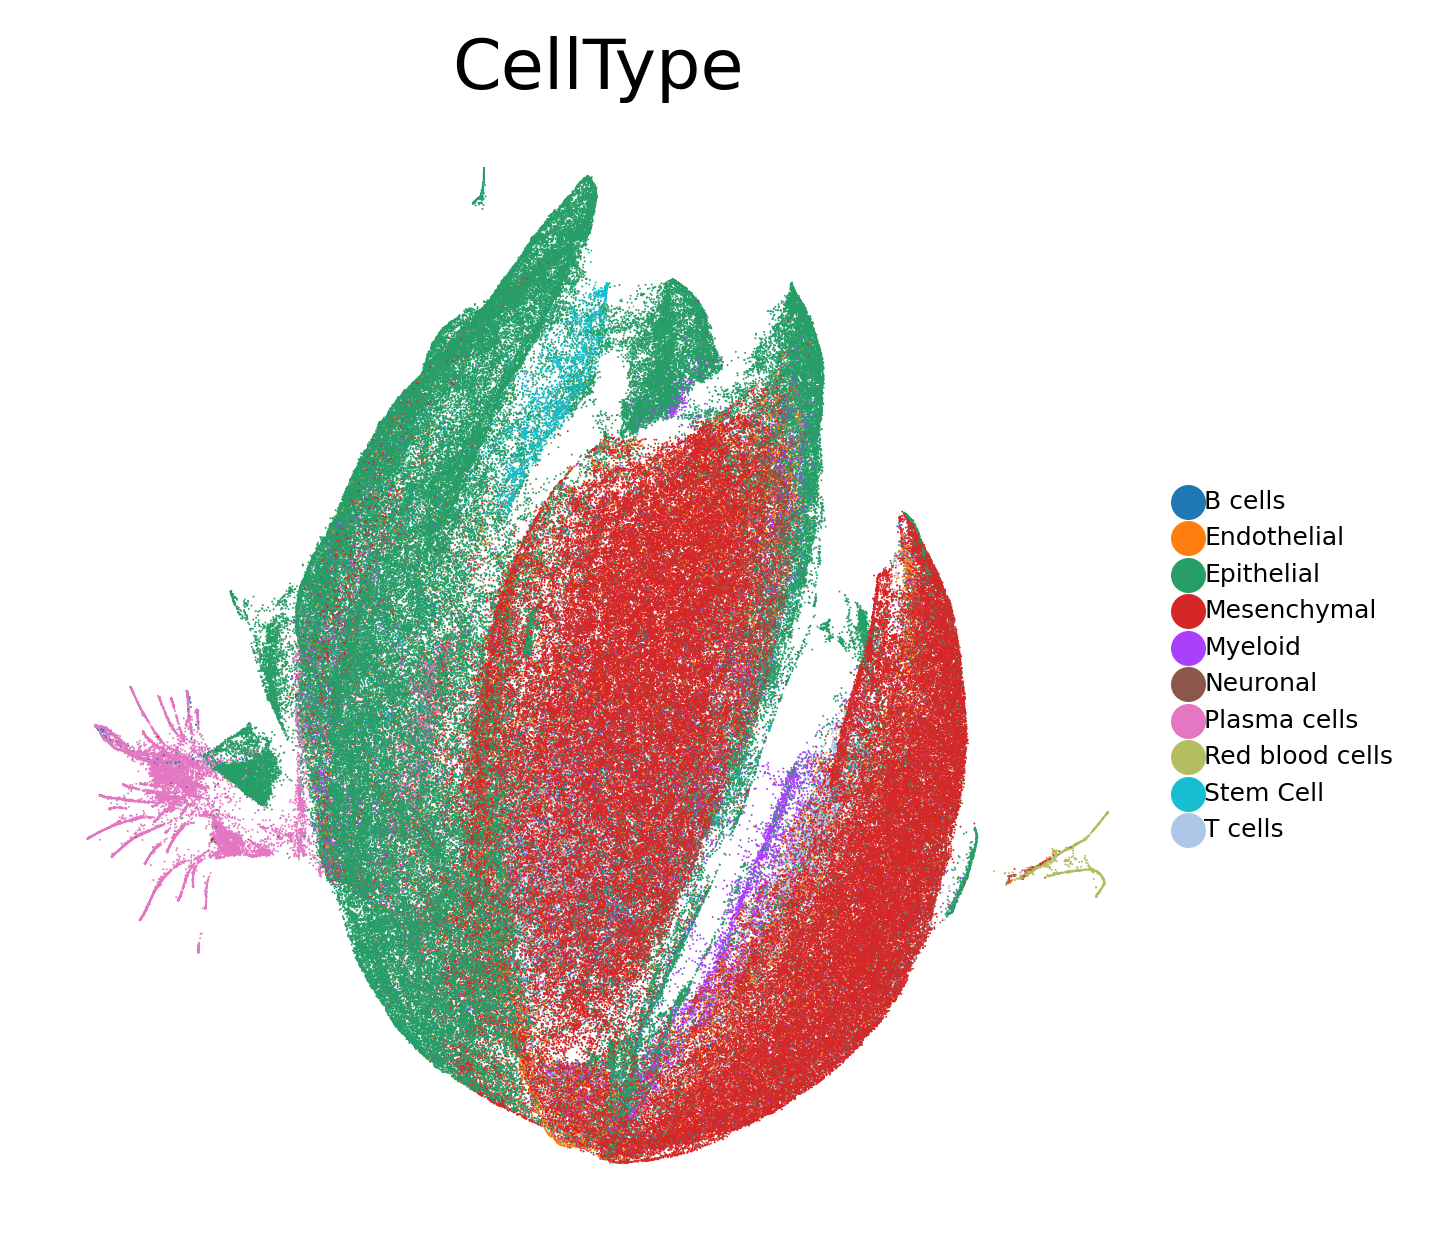

In [13]:
sc.pl.umap(andata, color=['CellType'], frameon=False, size = 0.6, legend_fontsize = 5, ncols = 3)

### Liana Run

In [7]:
# import all individual methods
import liana 
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

In [8]:
andata.layers['counts'] = andata.X.copy()

In [9]:
sc.pp.log1p(andata)

In [12]:
# run cellphonedb
cellphonedb(andata, groupby='Cell Label', expr_prop=0.1, verbose=True, use_raw=False)

Using `.X`!
4080 features of mat are empty, they will be removed.


/home/icb/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.02 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 375293 samples and 36064 features


100%|███████████████████████████████████████| 1000/1000 [41:33<00:00,  2.49s/it]


In [14]:
andata

AnnData object with n_obs × n_vars = 375293 × 40144
    obs: 'UniqueCell_ID', 'Sample_ID', 'CellType', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Gender', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts_mt', 'doublet_scores', 'predicted_doublets', 'Age_group', 'total_counts_ribo', 'Location', 'n_counts', 'percent_mito', 'percent_ribo', 'Cell States', 'Cell Label'
    uns: 'log1p', 'liana_res'
    layers: 'counts'

In [16]:
df = andata.obs['Cell Label'].value_counts()

In [18]:
#Write anndata object to file
andata.write('/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/Reference_maps/GCA_Stem_cells/All_cell_types/All_cell_types_after_liana.h5ad')

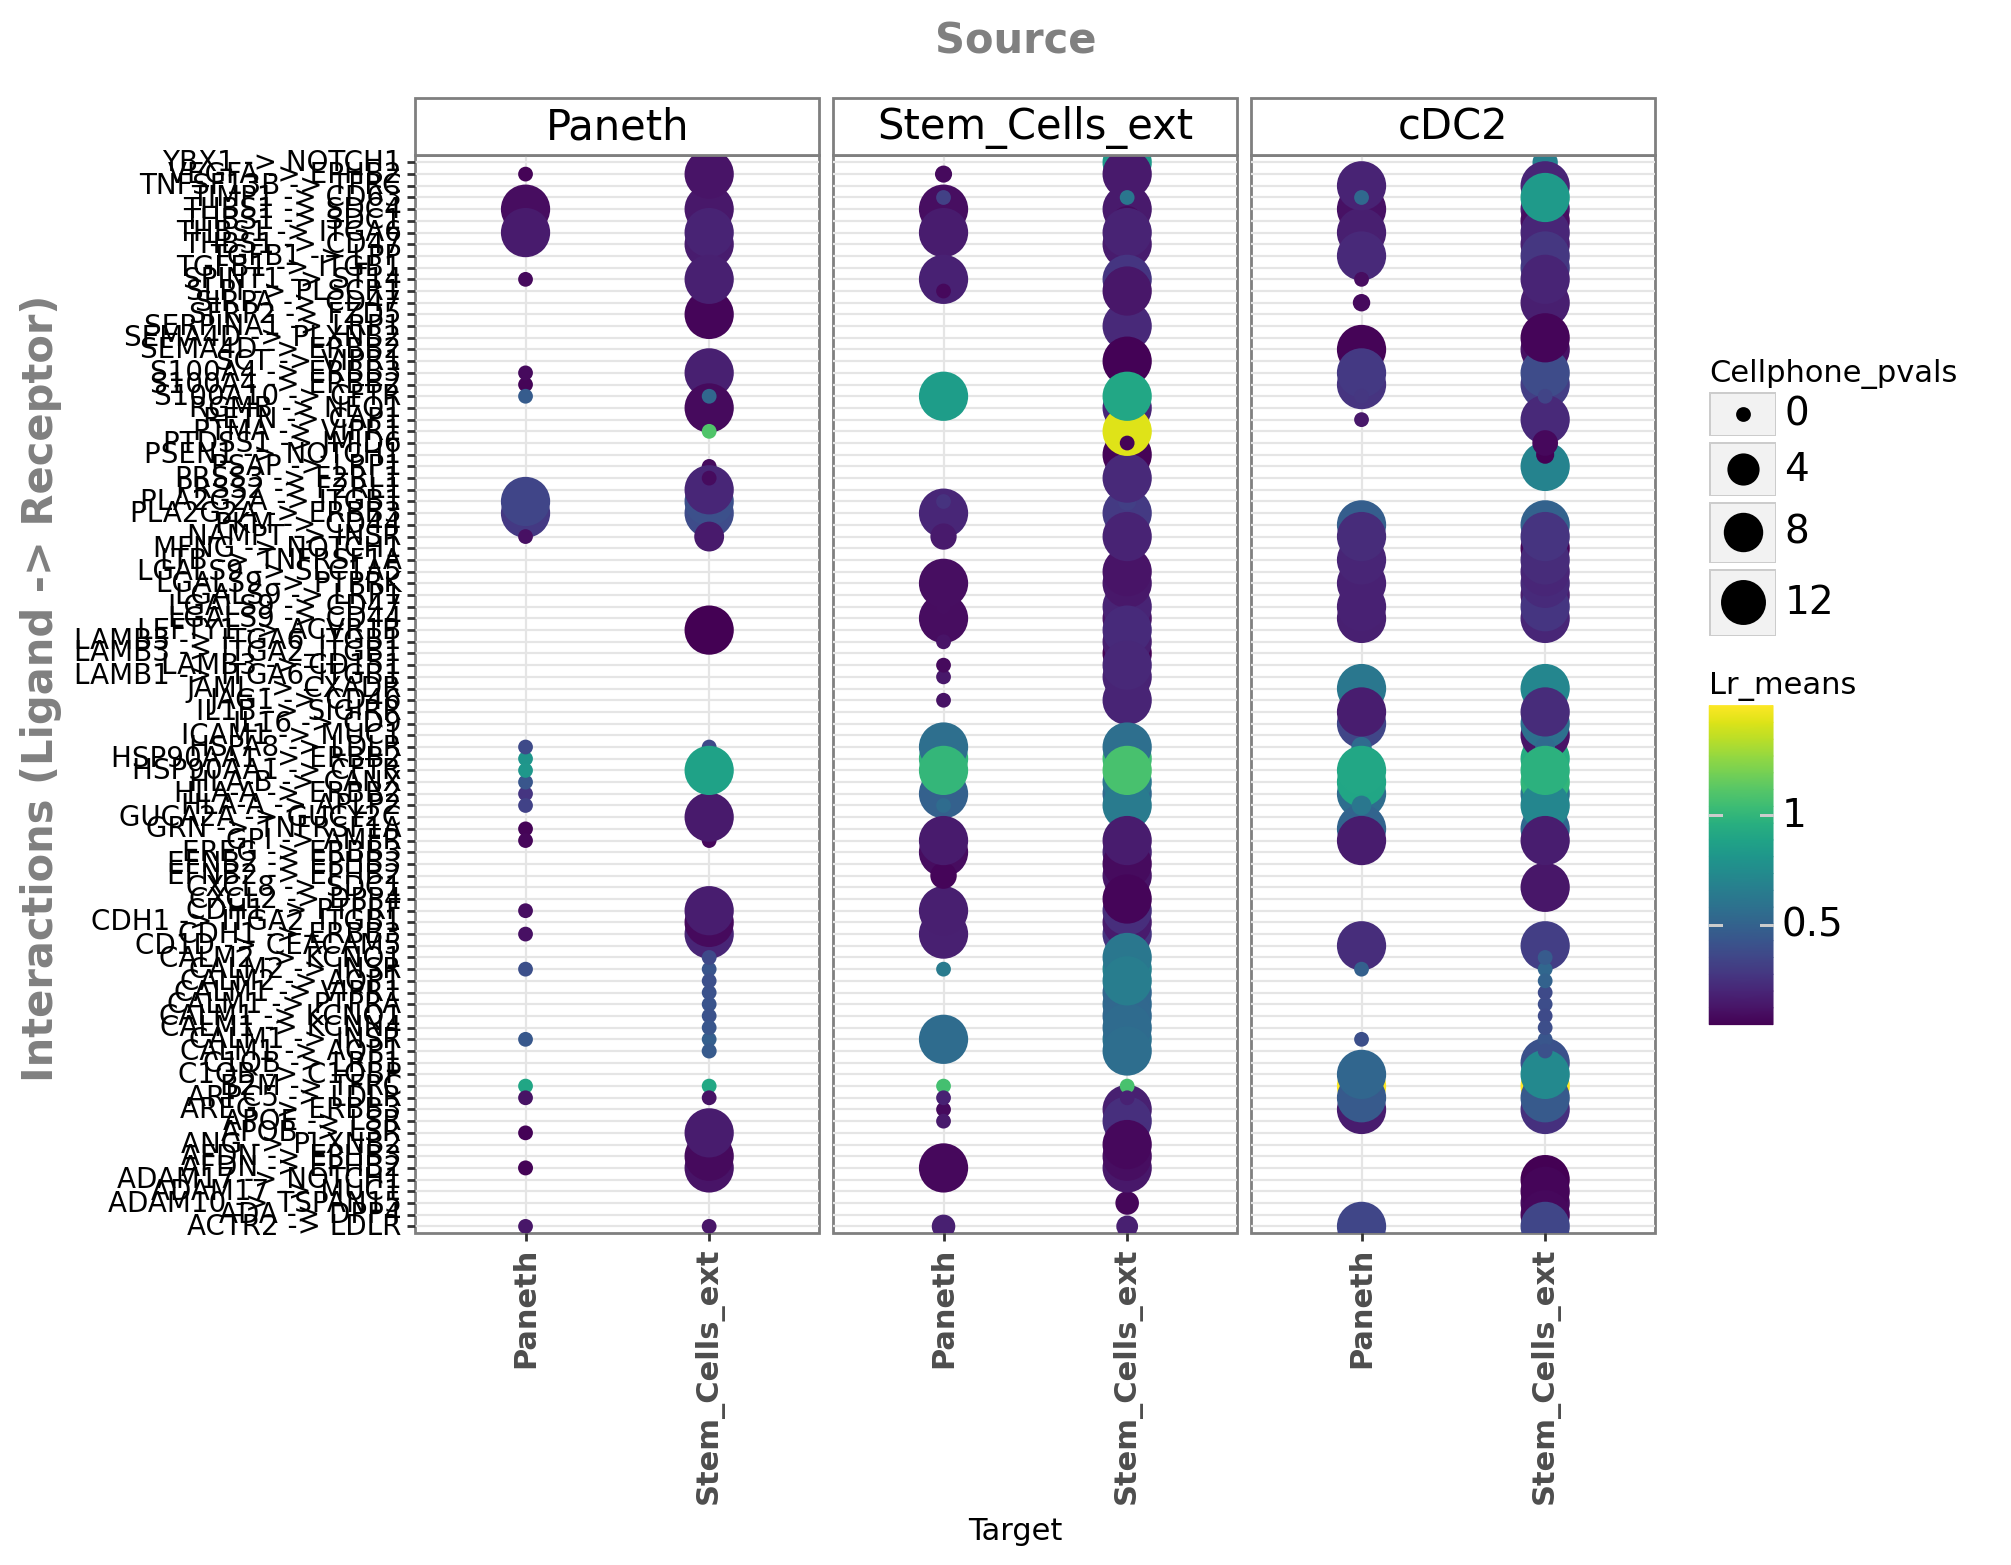

<ggplot: (8775701548689)>

In [17]:
li.pl.dotplot(adata = andata, 
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Stem_Cells_ext'],
              target_labels=['Paneth'],
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filterby='cellphone_pvals',
              filter_lambda=lambda x: x <= 0.05
             )